In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/apache-logs-cean-data/apache_logs_clean_data.csv


In [2]:
data = pd.read_csv("/kaggle/input/apache-logs-cean-data/apache_logs_clean_data.csv")
print(data.dtypes)
data.shape


Unnamed: 0            int64
status              float64
size                 object
referer              object
Label                object
request method       object
request path         object
request version      object
os                   object
hour                  int64
ip_numeric            int64
datetime_numeric    float64
dtype: object


(36554, 12)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [4]:
X = data.drop("Label", axis=1)
target_le = LabelEncoder()
y = target_le.fit_transform(data["Label"])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
categorical_cols = X.select_dtypes(include="object").columns.tolist()

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# Identify column types
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols)
])


# XGBoost

In [8]:
from collections import Counter
class_counts = Counter(y_train)
total = len(y_train)
class_weights = {cls: total/count for cls, count in class_counts.items()}

# Create sample weights array
sample_weights = np.array([class_weights[label] for label in y_train])

model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_counts),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

In [9]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Unnamed: 0', 'status',
                                                   'hour', 'ip_numeric',
                                                   'datetime_numeric']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['size', 'referer',
                                                   'request method',
                                                   'request path',
                                                   'request version',
                                                   'os'])])),
                ('classifier',
                 XGBClassifier(base_score=None, boost...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, num_class=3,
                               num_parallel_tree=None, ...))])

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

# Decode predictions and true labels for XGBoost
y_pred_xgb = xgb_pipeline.predict(X_test)
y_pred_text_xgb = target_le.inverse_transform(y_pred_xgb)
y_test_text_xgb = target_le.inverse_transform(y_test)

print("XGBoost Classification Report:\n")
print(classification_report(y_test_text_xgb, y_pred_text_xgb))


XGBoost Classification Report:

              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00       989
        Safe       1.00      1.00      1.00      5788
  Suspicious       1.00      0.99      1.00       534

    accuracy                           1.00      7311
   macro avg       1.00      1.00      1.00      7311
weighted avg       1.00      1.00      1.00      7311



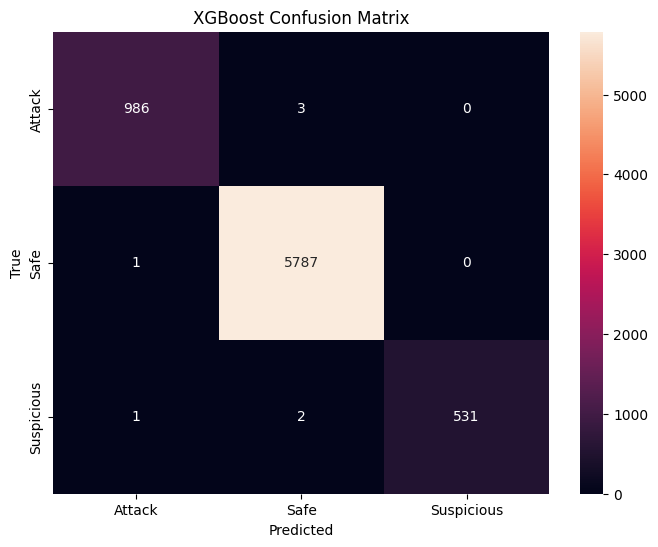

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Decode if needed for XGBoost
y_test_text = target_le.inverse_transform(y_test)
y_pred_text_xgb = target_le.inverse_transform(y_pred_xgb)

cm_xgb = confusion_matrix(y_test_text, y_pred_text_xgb, labels=target_le.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm_xgb, annot=True, fmt='d', xticklabels=target_le.classes_, yticklabels=target_le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost Confusion Matrix')
plt.show()


# Random Forest

In [12]:
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(class_weight="balanced", random_state=42))
])

In [13]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Unnamed: 0', 'status',
                                                   'hour', 'ip_numeric',
                                                   'datetime_numeric']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['size', 'referer',
                                                   'request method',
                                                   'request path',
                                                   'request version',
                                                   'os'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [14]:
rf_preds = rf_pipeline.predict(X_test)
rf_preds_text = target_le.inverse_transform(rf_preds)
labels = target_le.classes_  # This gets the original class names


In [15]:
print("Random Forest Classification Report:\n")
print(classification_report(y_test, rf_preds, target_names=target_le.classes_))

Random Forest Classification Report:

              precision    recall  f1-score   support

      Attack       0.99      0.99      0.99       989
        Safe       1.00      1.00      1.00      5788
  Suspicious       1.00      0.99      0.99       534

    accuracy                           1.00      7311
   macro avg       1.00      0.99      0.99      7311
weighted avg       1.00      1.00      1.00      7311



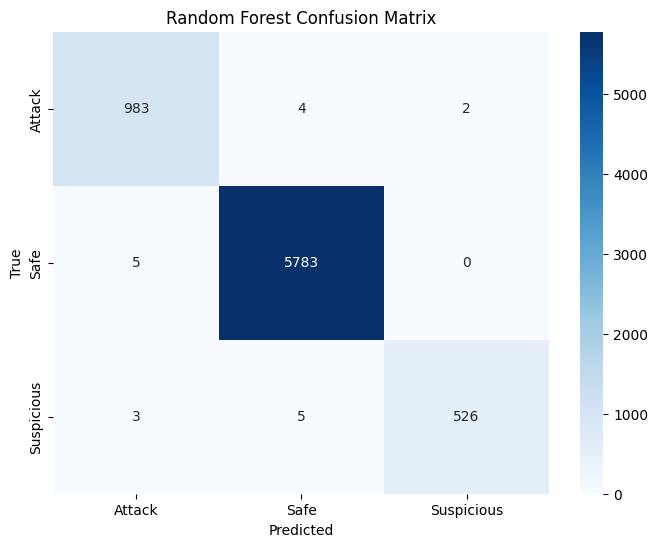

In [16]:
cm_rf = confusion_matrix(y_test_text, rf_preds_text, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Support Vector Machine

In [17]:
from sklearn.svm import LinearSVC

svm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LinearSVC(class_weight='balanced', max_iter=20000, dual=False))
])

In [18]:
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Unnamed: 0', 'status',
                                                   'hour', 'ip_numeric',
                                                   'datetime_numeric']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['size', 'referer',
                                                   'request method',
                                                   'request path',
                                                   'request version',
                                                   'os'])])),
                ('classifier',
                 LinearSVC(class_weight='balanced', dual=False,
                           max_iter=20000))])

In [19]:
svm_preds = svm_pipeline.predict(X_test)
svm_preds_text = target_le.inverse_transform(svm_preds)

In [20]:
print("\nSVM Classification Report:\n")
print(classification_report(y_test, svm_preds, target_names=target_le.classes_))


SVM Classification Report:

              precision    recall  f1-score   support

      Attack       0.87      0.98      0.92       989
        Safe       0.99      0.92      0.96      5788
  Suspicious       0.57      0.86      0.69       534

    accuracy                           0.93      7311
   macro avg       0.81      0.92      0.86      7311
weighted avg       0.95      0.93      0.93      7311



In [21]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

models = ['XGBoost', 'Random Forest', 'SVM']
metrics = ['Accuracy', 'Macro F1', 'Macro Precision', 'Macro Recall']

scores = [
    [accuracy_score(y_test_text, y_pred_text_xgb),
     f1_score(y_test_text, y_pred_text_xgb, average='macro'),
     precision_score(y_test_text, y_pred_text_xgb, average='macro'),
     recall_score(y_test_text, y_pred_text_xgb, average='macro')],

    
    [accuracy_score(y_test_text, rf_preds_text),
     f1_score(y_test_text, rf_preds_text, average='macro'),
     precision_score(y_test_text, rf_preds_text, average='macro'),
     recall_score(y_test_text, rf_preds_text, average='macro')],

    
    [accuracy_score(y_test_text, svm_preds_text),
     f1_score(y_test_text, svm_preds_text, average='macro'),
     precision_score(y_test_text, svm_preds_text, average='macro'),
     recall_score(y_test_text, svm_preds_text, average='macro')]
]


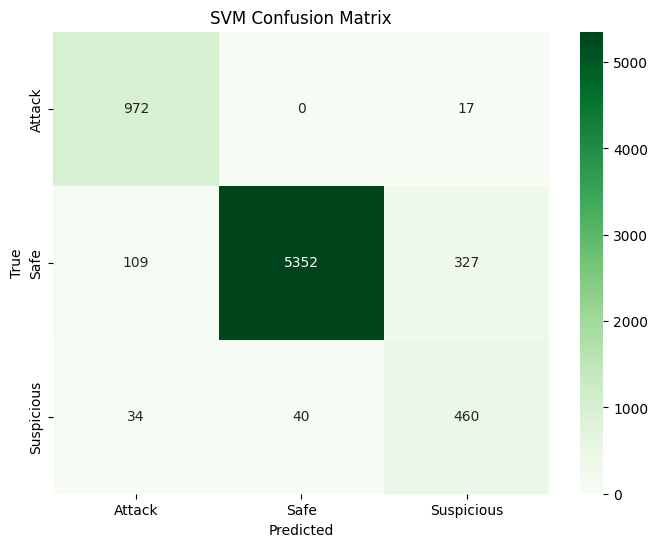

In [22]:
svm_preds_text = target_le.inverse_transform(svm_preds)
cm_svm = confusion_matrix(y_test_text, svm_preds_text, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


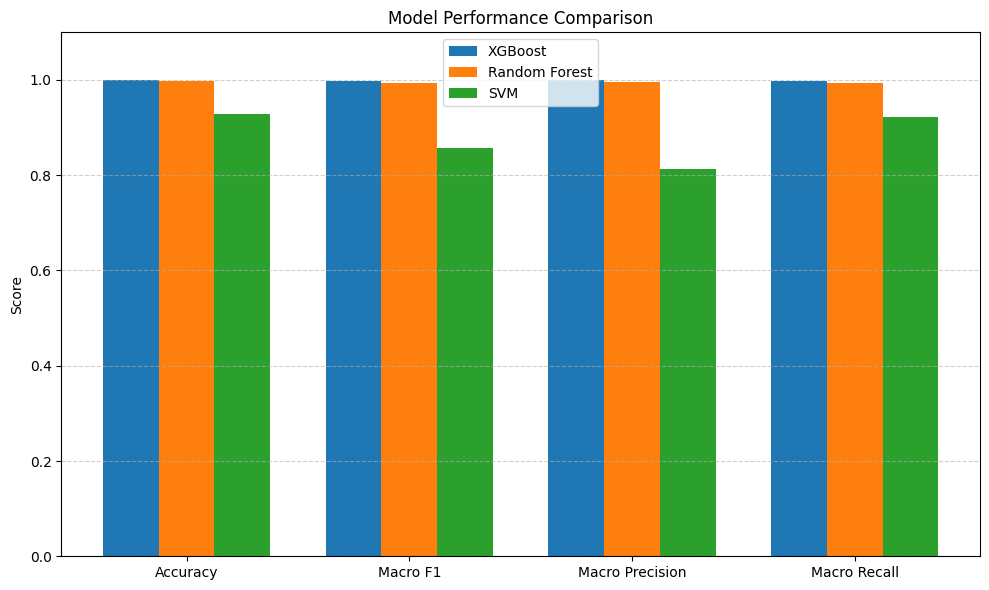

In [23]:
x = np.arange(len(metrics))
bar_width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(models)):
    ax.bar(x + i * bar_width, scores[i], width=bar_width, label=models[i])

ax.set_xticks(x + bar_width)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.legend()
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()